In [1]:
# Copyright (c) Nanjing University, Vision Lab.
# Last update: 2020.12.09

In [5]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pylab  as plt
import pandas as pd
tf.enable_eager_execution()

In [6]:
print(tf.__version__)
print(tf.test.is_gpu_available())

1.13.1
True


### set gpu/cpu

In [7]:
# os.environ['CUDA_VISIBLE_DEVICES']="" # only cpu

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
config.log_device_placement=True
# config.device_count={'gpu':0}
sess = tf.Session(config=config)

---
## Compression


###  Pre-process

In [8]:
from process import preprocess

In [9]:
input_file = 'testdata/8iVFB/longdress_vox10_1300.ply'
scale = 1.
cube_size = 64
min_num = 64
res = 1024

In [10]:
cubes, cube_positions, points_numbers = preprocess(input_file, scale, cube_size, min_num)

===== Preprocess =====
Scaling: 0.0s
Partition: 10.1974s
Voxelization: 0.1488s
cubes shape: (202, 64, 64, 64, 1)
points numbers (sum/mean/max/min): 857600 4246 11450 78


point_numbers (min/max/mean):  78 11450 4245


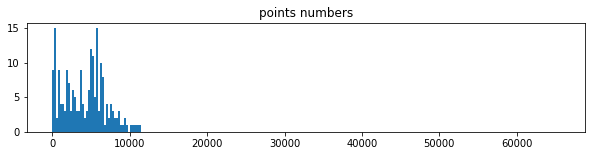

In [11]:
fig = plt.figure(figsize=(10,2))
print('point_numbers (min/max/mean): ', points_numbers.min(), points_numbers.max(), 
      int(points_numbers.mean()))
plt.title('points numbers')
n, bins, patches = plt.hist(points_numbers, bins=256, range=(1, pow(2, 16)))
plt.show()

### encoding

In [12]:
from transform import compress_factorized, decompress_factorized

In [13]:
import models.model_voxception as model
# import models.model_simple as model
# import models.model_quach as model
# import models.model_baseline as model
ckpt_dir = './checkpoints/factorized/a2b3/'

In [14]:
start = time.time()
strings, min_v, max_v, shape = compress_factorized(cubes, model, ckpt_dir)
print(time.time() - start)

===== Compress =====
Instructions for updating:
Colocations handled automatically by placer.
Analysis Transform: 7.4024s
Entropy Encode: 0.1356s
7.725878000259399


In [15]:
print(min_v.numpy(), max_v.numpy(), shape.numpy())

-2 2 [202  16  16  16  16]


### Write files

In [16]:
from dataprocess.inout_bitstream import write_binary_files_factorized
filename = os.path.split(input_file)[-1][:-4]
rootdir = './compressed/'
print(rootdir, filename)

bytes_strings, bytes_pointnums, bytes_cubepos = write_binary_files_factorized(
    filename, strings.numpy(), points_numbers, cube_positions,
    min_v.numpy(), max_v.numpy(), shape.numpy(), rootdir)

./compressed/ longdress_vox10_1300
===== Write binary files =====
Total file size (Bytes): 13960
Strings (Bytes): 13466
Numbers of points (Bytes): 404
Positions of cubes (Bytes): 90


In [17]:
import subprocess
subp=subprocess.Popen("ls ./compressed/", 
                      shell=True, stdout=subprocess.PIPE)
c=subp.stdout.readline()
while c:
    print (c)
    c=subp.stdout.readline()

b'longdress_vox10_1300.cubepos\n'
b'longdress_vox10_1300_cubepos.ply\n'
b'longdress_vox10_1300.pointnums\n'
b'longdress_vox10_1300.strings\n'
b'longdress_vox10_1300.strings_head\n'
b'longdress_vox10_1300.strings_hyper\n'


---
## Decompress

### Read files

In [18]:
from dataprocess.inout_bitstream import read_binary_files_factorized
strings_d, points_numbers_d, cube_positions_d, min_v_d, max_v_d, shape_d = \
                                            read_binary_files_factorized(filename, rootdir)

===== Read binary files =====


### decoding

In [19]:
from transform import decompress_factorized
cubes_d = decompress_factorized(strings_d, min_v_d, max_v_d, shape_d, model, ckpt_dir)

===== Decompress =====
Entropy Decode: 0.1505s
Synthesis Transform: 6.7069s


In [20]:
# _ = plt.hist(cubes_d.numpy().reshape(-1), bins=512)

### post-process

In [21]:
from process import postprocess
rho = 1.0
output_file = filename + "_rec.ply"
postprocess(output_file, cubes_d.numpy(), 
            points_numbers_d, cube_positions_d, scale, cube_size, rho)

===== Post process =====
Classify and extract points: 0.649s
Write point cloud to longdress_vox10_1300_rec.ply: 3.2594s


---
## Metrics

### bpp

In [22]:
def get_points_number(filedir):
    plyfile = open(filedir)

    line = plyfile.readline()
    while line.find("element vertex") == -1:
        line = plyfile.readline()
    number = int(line.split(' ')[-1][:-1])
    
    return number

In [23]:
N = get_points_number(input_file)
print(N)

857966


In [24]:
print("bpp: ", round(8*(bytes_strings + bytes_pointnums + bytes_cubepos)/float(N), 4))
print("strings: ", round(8*bytes_strings/float(N),4), 
      "points numbers: ", round(8*bytes_pointnums/float(N),4), 
      "cubes positions: ", round(8*bytes_cubepos/float(N),4))

bpp:  0.1302
strings:  0.1256 points numbers:  0.0038 cubes positions:  0.0008


### pc_error

In [25]:
import subprocess

subp=subprocess.Popen("myutils/pc_error_d" 
                      + ' -a ' + input_file
                      + ' -b ' + output_file
                      +' -n ' + input_file 
                      + ' --hausdorff=1 '
                      + " -r "+str(res-1), 
                      shell=True, stdout=subprocess.PIPE)

c=subp.stdout.readline()
while c:
    print(c)
    c=subp.stdout.readline()

print(subp.returncode)

b'PCC quality measurement software, version 0.13.4\n'
b'\n'
b'infile1:        testdata/8iVFB/longdress_vox10_1300.ply\n'
b'infile2:        longdress_vox10_1300_rec.ply\n'
b'normal1:        testdata/8iVFB/longdress_vox10_1300.ply\n'
b'singlePass:     0\n'
b'hausdorff:      1\n'
b'color:          0\n'
b'lidar:          0\n'
b'resolution:     1023\n'
b'dropDuplicates: 2\n'
b'neighborsProc:  1\n'
b'averageNormals: 1\n'
b'nbThreads:      1\n'
b'\n'
b'Verifying if the data is loaded correctly.. The last point is: 256 902 320\n'
b'Reading file 1 done.\n'
b'Normals loaded from file1.\n'
b'Verifying if the data is loaded correctly.. The last point is: 223 960 320\n'
b'Reading file 2 done.\n'
b'Imported intrinsic resoluiton: 1023\n'
b'Peak distance for PSNR: 1023\n'
b'Point cloud sizes for org version, dec version, and the scaling ratio: 857966, 857600, 0.999573\n'
b'Normals prepared.\n'
b'\n'
b'1. Use infile1 (A) as reference, loop over A, use normals on B. (A->B).\n'
b'   mse1      (p2point): 

In [26]:
import open3d as o3d
pcd = o3d.io.read_point_cloud(input_file)

In [27]:
o3d.visualization.draw_geometries([pcd])

In [28]:
pcd_rec = o3d.io.read_point_cloud(output_file)
o3d.visualization.draw_geometries([pcd_rec])

---
# Model with Hyperprior

In [33]:
input_file = 'testdata/8iVFB/longdress_vox10_1300.ply'
scale = 1.
cube_size = 64
min_num = 64
res = 1024

In [34]:
from process import preprocess
cubes, cube_positions, points_numbers = preprocess(input_file, scale, cube_size, min_num)

===== Preprocess =====
Scaling: 0.0s
Partition: 10.4049s
Voxelization: 0.4471s
cubes shape: (202, 64, 64, 64, 1)
points numbers (sum/mean/max/min): 857600 4246 11450 78


## compress

In [49]:
import models.model_voxception as model
from transform import compress_hyper
ckpt_dir = './checkpoints/hyper/a0.75b3/'

In [50]:
start = time.time()
y_strings, y_min_vs, y_max_vs, y_shape, z_strings, z_min_v, z_max_v, z_shape, x_ds = \
compress_hyper(cubes, model, ckpt_dir, True)
print(round(time.time() - start, 4))

===== Compress =====
Analysis Transform: 5.839s
Hyper Encoder: 0.18s
Quantize hyperprior.
Hyper Decoder: 0.3564s
Entropy Encode (Hyper): 0.0091s
Entropy Encode: 1.3656s
Entropy Decode: 1.3281s
Synthesis Transform: 6.6119s
15.9921


In [51]:
from dataprocess.inout_bitstream import write_binary_files_hyper
filename = os.path.split(input_file)[-1][:-4]
rootdir = './compressed/'

bytes_strings, bytes_strings_head, bytes_strings_hyper, bytes_pointnums, bytes_cubepos = \
    write_binary_files_hyper(
    filename, y_strings.numpy(), z_strings.numpy(), points_numbers, cube_positions,
    y_min_vs.numpy(), y_max_vs.numpy(), y_shape.numpy(), 
    z_min_v.numpy(), z_max_v.numpy(), z_shape.numpy(), rootdir)

===== Write binary files =====
Total file size (Bytes): 12148
Strings (Bytes): 7128
Strings head (Bytes): 416
Strings hyper (Bytes): 4110
Numbers of points (Bytes): 404
Positions of cubes (Bytes): 90


## decompress

In [52]:
from dataprocess.inout_bitstream import read_binary_files_hyper
y_strings_d, z_strings_d, points_numbers_d, cube_positions_d, \
y_min_vs_d, y_max_vs_d, y_shape_d, z_min_v_d, z_max_v_d, z_shape_d = \
read_binary_files_hyper(filename, rootdir)

===== Read binary files =====


In [53]:
from transform import decompress_hyper
cubes_d = decompress_hyper(y_strings_d, y_min_vs_d.astype('int32'), y_max_vs_d.astype('int32'), y_shape_d, 
                     z_strings_d, z_min_v_d, z_max_v_d, z_shape_d, model, ckpt_dir)

===== Decompress =====
Entropy Decoder (Hyper): 0.026s
Hyper Decoder: 0.3464s
Entropy Decoder: 1.3539s
Synthesis Transform: 6.6596s


In [54]:
# check
print("error on gpu:", tf.reduce_max(tf.abs(cubes_d - x_ds)).numpy())

error on gpu: 1.1444092e-05


In [55]:
from process import postprocess
# cubes_d = x_ds
rho = 1.0
output_file = filename + "_rec.ply"
print(output_file)

postprocess(output_file, cubes_d.numpy(), 
            points_numbers_d, cube_positions_d, scale, cube_size, rho)
# cheat
# postprocess(output_file, x_ds, points_numbers_d, cube_positions_d, scale, cube_size, rho)

longdress_vox10_1300_rec.ply
===== Post process =====
Classify and extract points: 0.359s
Write point cloud to longdress_vox10_1300_rec.ply: 3.3553s


## metric

In [56]:
def get_points_number(filedir):
    plyfile = open(filedir)

    line = plyfile.readline()
    while line.find("element vertex") == -1:
        line = plyfile.readline()
    number = float(line.split(' ')[-1][:-1])
    
    return number

N = get_points_number(input_file)
print(N)

print("bpp: ", 
      round(8*(bytes_strings 
               + bytes_strings_head + 
               bytes_strings_hyper + 
               bytes_pointnums + 
               bytes_cubepos)/N,4))
print("strings: ", round(8*bytes_strings/N,4), 
      "strings_hyper: ", round(8*bytes_strings_hyper/N,4), '\n', 
      "strings_head: ", round(8*bytes_strings_head/N,4), 
      "points numbers: ", round(8*bytes_pointnums/N,4), 
      "cubes positions: ", round(8*bytes_cubepos/N,4))

857966.0
bpp:  0.1133
strings:  0.0665 strings_hyper:  0.0383 
 strings_head:  0.0039 points numbers:  0.0038 cubes positions:  0.0008


In [57]:
import subprocess

input_file_n = input_file[:-4]+'.ply'
subp=subprocess.Popen("myutils/pc_error_d" 
                      + ' -a ' + input_file
                      + ' -b ' + output_file
                      +' -n ' + input_file 
                      + ' --hausdorff=1 '
                      + " -r "+str(res-1), 
                      shell=True, stdout=subprocess.PIPE)

c=subp.stdout.readline()
while c:
    print(c)
    c=subp.stdout.readline()

print(subp.returncode)

b'PCC quality measurement software, version 0.13.4\n'
b'\n'
b'infile1:        testdata/8iVFB/longdress_vox10_1300.ply\n'
b'infile2:        longdress_vox10_1300_rec.ply\n'
b'normal1:        testdata/8iVFB/longdress_vox10_1300.ply\n'
b'singlePass:     0\n'
b'hausdorff:      1\n'
b'color:          0\n'
b'lidar:          0\n'
b'resolution:     1023\n'
b'dropDuplicates: 2\n'
b'neighborsProc:  1\n'
b'averageNormals: 1\n'
b'nbThreads:      1\n'
b'\n'
b'Verifying if the data is loaded correctly.. The last point is: 256 902 320\n'
b'Reading file 1 done.\n'
b'Normals loaded from file1.\n'
b'Verifying if the data is loaded correctly.. The last point is: 220 960 323\n'
b'Reading file 2 done.\n'
b'Imported intrinsic resoluiton: 1023\n'
b'Peak distance for PSNR: 1023\n'
b'Point cloud sizes for org version, dec version, and the scaling ratio: 857966, 857600, 0.999573\n'
b'Normals prepared.\n'
b'\n'
b'1. Use infile1 (A) as reference, loop over A, use normals on B. (A->B).\n'
b'   mse1      (p2point): 

In [58]:
import open3d as o3d
pcd = o3d.io.read_point_cloud(input_file)
o3d.visualization.draw_geometries([pcd])

In [59]:
pcd_rec = o3d.io.read_point_cloud(output_file)
o3d.visualization.draw_geometries([pcd_rec])

## select optimal rho

In [60]:
from myutils.pc_error_wrapper import pc_error

In [61]:
def select_rho(item, input_file, output_file, input_file_n, 
               cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res):
    steps = [0.05]*6+[0.10]*3
    MAX = 0
    rho = 1.0
    optimal_rho = 1.0

    for i, step in enumerate(steps):
        print('===== select rho =====')
        print(rho)
        postprocess(output_file, cubes_d.numpy(), 
                    points_numbers_d, cube_positions_d, scale, cube_size, rho)
        results = pc_error(input_file, output_file, input_file_n, res, show=False)
        
        # record results.
        results["n_points"] = get_points_number(output_file)
        results["rho"] = rho
        if i == 0:
            all_results = results.copy(deep=True)
        else:
            all_results = all_results.append(results, ignore_index=True)
        
        PSNR = float(results[item])
        print('===== results: ', i, rho, item, PSNR)
        MAX = max(PSNR, MAX)
        if PSNR < MAX:
            break
        else:
            optimal_rho = rho
        if item == "mseF,PSNR (p2point)":
            rho += step
        elif item == "mseF,PSNR (p2plane)":
            rho -= step
        else:
            print('ERROR', item)
            break
    return optimal_rho, all_results

In [62]:
optimal_d1, all_results = select_rho("mseF,PSNR (p2point)", input_file, output_file, input_file_n, 
                        cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res)

===== select rho =====
1.0
===== Post process =====
Classify and extract points: 0.4908s
Write point cloud to longdress_vox10_1300_rec.ply: 3.2203s
===== measure PCC quality using `pc_error` version 0.13.4 21.9627
===== results:  0 1.0 mseF,PSNR (p2point) 67.7148
===== select rho =====
1.05
===== Post process =====
Classify and extract points: 0.3364s
Write point cloud to longdress_vox10_1300_rec.ply: 3.2875s
===== measure PCC quality using `pc_error` version 0.13.4 22.3718
===== results:  1 1.05 mseF,PSNR (p2point) 68.1193
===== select rho =====
1.1
===== Post process =====
Classify and extract points: 0.3391s
Write point cloud to longdress_vox10_1300_rec.ply: 3.4846s
===== measure PCC quality using `pc_error` version 0.13.4 22.9781
===== results:  2 1.1 mseF,PSNR (p2point) 68.5022
===== select rho =====
1.1500000000000001
===== Post process =====
Classify and extract points: 0.3451s
Write point cloud to longdress_vox10_1300_rec.ply: 3.5812s
===== measure PCC quality using `pc_error` 

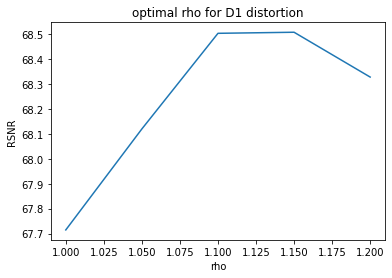

In [63]:
plt.plot(np.array(all_results["rho"][:]), np.array(all_results["mseF,PSNR (p2point)"][:]))
plt.title("optimal rho for D1 distortion")
_ = plt.xlabel('rho')
_ = plt.ylabel('RSNR')

In [64]:
optimal_d2, all_results = select_rho("mseF,PSNR (p2plane)", input_file, output_file, input_file_n, 
                        cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res)

===== select rho =====
1.0
===== Post process =====
Classify and extract points: 0.7957s
Write point cloud to longdress_vox10_1300_rec.ply: 3.2509s
===== measure PCC quality using `pc_error` version 0.13.4 22.0556
===== results:  0 1.0 mseF,PSNR (p2plane) 71.1413
===== select rho =====
0.95
===== Post process =====
Classify and extract points: 0.3473s
Write point cloud to longdress_vox10_1300_rec.ply: 3.0599s
===== measure PCC quality using `pc_error` version 0.13.4 21.2694
===== results:  1 0.95 mseF,PSNR (p2plane) 71.3808
===== select rho =====
0.8999999999999999
===== Post process =====
Classify and extract points: 0.3454s
Write point cloud to longdress_vox10_1300_rec.ply: 2.8367s
===== measure PCC quality using `pc_error` version 0.13.4 20.7336
===== results:  2 0.8999999999999999 mseF,PSNR (p2plane) 71.5715
===== select rho =====
0.8499999999999999
===== Post process =====
Classify and extract points: 0.342s
Write point cloud to longdress_vox10_1300_rec.ply: 2.7797s
===== measure 

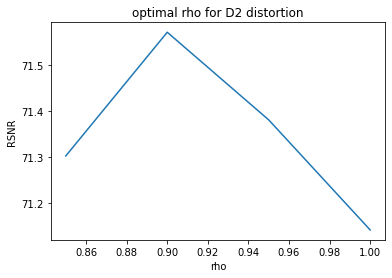

In [65]:
plt.plot(np.array(all_results["rho"][:]), np.array(all_results["mseF,PSNR (p2plane)"][:]))
plt.title("optimal rho for D2 distortion")
_ = plt.xlabel('rho')
_ = plt.ylabel('RSNR')